In [121]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
import pandas as pd

def split_by_min_thresh(X, y, feat_index, partition_mask=None):
    thresh = np.unique(X[:,feat_index]).reshape(1,-1)
    selected_feat = X[:,feat_index].reshape(-1,1)
    is_left_sampler = (selected_feat <= thresh)
    is_right_sampler = ~is_left_sampler

    # print('X.shape = ', X.shape)
    # print('thresh.shape = ', thresh.shape)
    # print('is_left_sampler.shape = ', is_left_sampler.shape)
    # print('is_right_sampler.shape = ', is_right_sampler.shape)

    # print('partition_mask.shape = ', partition_mask.shape)
    if partition_mask is not None:
        partition_mask = np.hstack(is_left_sampler.shape[1] * [partition_mask.reshape(-1,1)])
        is_left_sampler = is_left_sampler & partition_mask
        is_right_sampler = is_right_sampler & partition_mask
    
    stacked_targets = np.hstack([y.reshape(-1,1)] * is_left_sampler.shape[1])
    left_sampled, right_sampled = is_left_sampler * stacked_targets, is_right_sampler * stacked_targets

    n_samples_left, n_samples_right = np.sum(is_left_sampler, axis=0), np.sum(is_right_sampler, axis=0)

    with np.errstate(divide='ignore', invalid='ignore'):
        left_samples_mean = np.where(n_samples_left == 0, 0, np.sum(left_sampled, axis=0) / n_samples_left)
        right_samples_mean = np.where(n_samples_right == 0, 0, np.sum(right_sampled, axis=0) / n_samples_right)
    
    var_left = is_left_sampler * (left_sampled - left_samples_mean.reshape(1,-1)) ** 2
    var_right = (is_right_sampler) * (right_sampled - right_samples_mean.reshape(1,-1)) ** 2

    with np.errstate(divide='ignore', invalid='ignore'):
        var_left = np.where(n_samples_left == 0, 0, np.sum(var_left, axis=0) / n_samples_left)
        var_right = np.where(n_samples_right == 0, 0, np.sum(var_right, axis=0) / n_samples_right)

    total_samples = left_sampled.shape[0]
    assert total_samples == right_sampled.shape[0], 'wrong total samples'

    ratio_left, ratio_right = n_samples_left / total_samples, n_samples_right / total_samples
    thresh_cost = ratio_left * var_left + ratio_right * var_right
    min_thresh_index = np.argmin(thresh_cost)

    min_cost = np.min(thresh_cost)
    # left_indices = np.nonzero(is_left_sampler[:, min_thresh_index])[0]
    # right_indices = np.nonzero(~is_left_sampler[:, min_thresh_index])[0]
    left_partition_mask = is_left_sampler[:, min_thresh_index]
    right_partition_mask = is_right_sampler[:, min_thresh_index]
    left_count = np.sum(is_left_sampler[:, min_thresh_index])
    right_count = np.sum(is_right_sampler[:, min_thresh_index])    
    min_thresh = thresh.reshape(-1)[min_thresh_index]

    return left_partition_mask, right_partition_mask, left_count, right_count, min_cost, min_thresh

def split_by_min_feat_thresh(X, y, partition):
    feat_count = X.shape[1]
    data_count = X.shape[0]

    min_left_partition, min_right_partition, min_left_count, min_right_count, min_cost, min_thresh = split_by_min_thresh(X, y, 0, partition)
    min_feat_index = 0

    for feat_index in range(1, feat_count):
        left_partition, right_partition, left_count, right_count, cost, thresh = split_by_min_thresh(X, y, feat_index, partition)
        # print(f'[{feat_index}/{feat_count}] cost = {cost}, thresh = {thresh}')
        # assert left_count + right_count == data_count, 'left_count + right_count != data_count'
        if min_cost > cost:
            min_left_partition = left_partition
            min_right_partition = right_partition 
            min_left_count = left_count
            min_right_count = right_count
            min_cost = cost
            min_thresh = thresh
            min_feat_index = feat_index

    return min_left_partition, min_right_partition, min_left_count, min_right_count, min_feat_index, min_cost, min_thresh
    

In [125]:
data = load_diabetes()
X,y = data['data'], data['target']

current_right_partition = None
min_count = 1
partition_lists = []
current_count = X.shape[0]
current_depth = 1
max_depth = 10

while current_count > min_count and max_depth > current_depth: 
    left_partition, right_partition, left_count, right_count, feat_index, cost, thresh = split_by_min_feat_thresh(X,y, current_right_partition)

    # if current_depth > 1:
        # break
    
    print(f'[{current_depth}/{max_depth}] right_count = {right_count}, cost = {cost}, feat_index = {feat_index}, thresh = {thresh}')
    current_count = right_count
    partition_lists.append(right_partition.reshape(-1,1))
    current_right_partition = right_partition
    current_depth += 1
    print(f'current_count = {current_count}')


[1/10] right_count = 224, cost = 4201.076466066314, feat_index = 8, thresh = -0.00422151393810765
current_count = 224
[2/10] right_count = 108, cost = 2097.272926382459, feat_index = 2, thresh = 0.014272475267928093
current_count = 108
[3/10] right_count = 31, cost = 840.5301832891967, feat_index = 2, thresh = 0.0681630789619681
current_count = 31
[4/10] right_count = 12, cost = 98.02914384377232, feat_index = 5, thresh = 0.02154596028441731
current_count = 12
[5/10] right_count = 11, cost = 23.75277663512957, feat_index = 4, thresh = 0.014942474478202204
current_count = 11
[6/10] right_count = 10, cost = 14.32601809954751, feat_index = 6, thresh = -0.06180903467245962
current_count = 10
[7/10] right_count = 8, cost = 8.091628959276019, feat_index = 4, thresh = 0.02182223876920781
current_count = 8
[8/10] right_count = 3, cost = 3.916742081447964, feat_index = 9, thresh = 0.040343371647878594
current_count = 3
[9/10] right_count = 1, cost = 0.1911764705882353, feat_index = 0, thresh = 

9
(442, 1)
(442, 9)


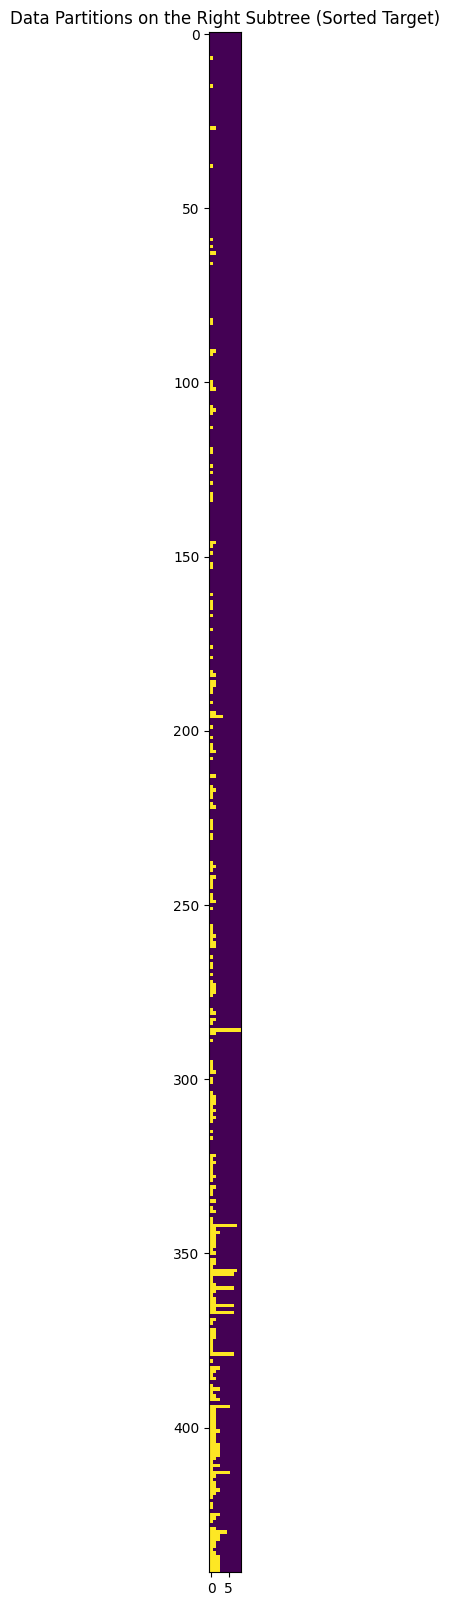

In [126]:
data_partitions_right = np.hstack(partition_lists)
print(len(partition_lists))
print(partition_lists[0].shape)
print(data_partitions_right.shape)

feat_cols = [f'x{count}' for count in range(0, data_partitions_right.shape[1])] 
cols = feat_cols + ['y']
data_partitions_right = np.hstack([data_partitions_right, y.reshape(-1,1)])
data_partitions_right = pd.DataFrame(data_partitions_right, columns=cols)
data_partitions_right = data_partitions_right.sort_values(by='y')

plt.figure(figsize=(5,20))
plt.imshow(data_partitions_right[feat_cols])
plt.title('Data Partitions on the Right Subtree (Sorted Target)')
plt.show()

In [129]:
data = load_diabetes()
X,y = data['data'], data['target']

current_left_partition = None
min_count = 1
partition_lists = []
current_count = X.shape[0]
current_depth = 1
max_depth = 10

while current_count > min_count and max_depth > current_depth: 
    left_partition, right_partition, left_count, right_count, feat_index, cost, thresh = split_by_min_feat_thresh(X,y, current_left_partition)

    print(f'[{current_depth}/{max_depth}] left_count = {left_count}, right_count = {right_count}, cost = {cost}, feat_index = {feat_index}, thresh = {thresh}')
    current_count = left_count
    partition_lists.append(left_partition.reshape(-1,1))
    current_left_partition = left_partition
    current_depth += 1
    print(f'current_count = {current_count}')

[1/10] left_count = 218, right_count = 224, cost = 4201.076466066314, feat_index = 8, thresh = -0.00422151393810765
current_count = 218
[2/10] left_count = 171, right_count = 47, cost = 1262.7771702932755, feat_index = 2, thresh = 0.005649978676881689
current_count = 171
[3/10] left_count = 87, right_count = 84, cost = 766.8987277935046, feat_index = 6, thresh = 0.019186997017453092
current_count = 87
[4/10] left_count = 85, right_count = 2, cost = 480.77132020228925, feat_index = 4, thresh = 0.04934129593323023
current_count = 85
[5/10] left_count = 39, right_count = 46, cost = 451.91980810847633, feat_index = 1, thresh = -0.044641636506989144
current_count = 39
[6/10] left_count = 21, right_count = 18, cost = 225.88041370394313, feat_index = 3, thresh = -0.03665608107540074
current_count = 21
[7/10] left_count = 8, right_count = 13, cost = 80.05186216498434, feat_index = 0, thresh = -0.052737554842062495
current_count = 8
[8/10] left_count = 1, right_count = 7, cost = 21.152553329023

8
(442, 1)
(442, 8)


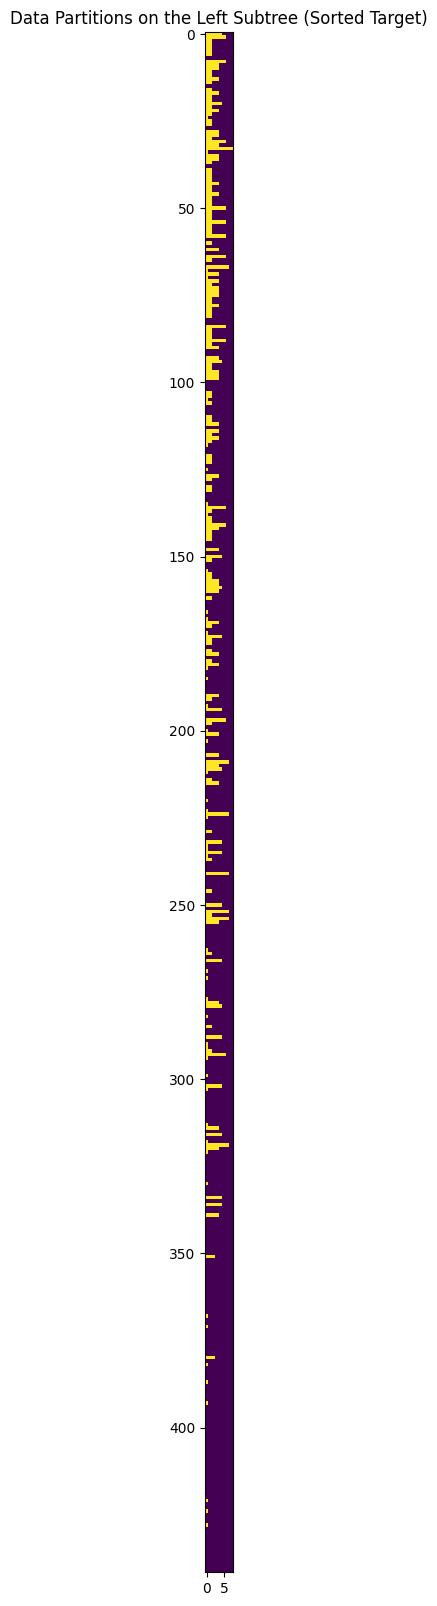

In [130]:
data_partitions_left = np.hstack(partition_lists)
print(len(partition_lists))
print(partition_lists[0].shape)
print(data_partitions_left.shape)

feat_cols = [f'x{count}' for count in range(0, data_partitions_left.shape[1])] 
cols = feat_cols + ['y']
data_partitions_left = np.hstack([data_partitions_left, y.reshape(-1,1)])
data_partitions_left = pd.DataFrame(data_partitions_left, columns=cols)
data_partitions_left = data_partitions_left.sort_values(by='y')

plt.figure(figsize=(5,20))
plt.imshow(data_partitions_left[feat_cols])
plt.title('Data Partitions on the Left Subtree (Sorted Target)')
plt.show()

In [82]:
figsize = (25,10)
fig, axs = plt.subplots(1, 2, figsize=figsize)

(442,)